# Transfer Learning using fastAI and ResNet34

FastAI is a library running on top of PyTorch, which allows quick and flexible image classifiers to be made. On top of that the techniques used in fastAI image classifications allows it to be one of the best libraries in terms of **accuracy**.

Some or all of the techniques to improve image classification has been used here.

## Steps proposed by fastAI which yields a better a classifier

1. Find the learning rate.
2. Fit the model with the learning rate for ~6 epochs.
3. Turn precompute off (in order to augment).
4. Re-run fit for ~3 epochs.
5. Unfreeze last couple of layers.
6. Re-run fit with slightly varying learning rates, ~3 epochs, with a cycle_len=1 and cycle_mult-2.
7. Save weights.
8. Repeat with a larger image size.

In [1]:
import os
import pandas as pd
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
PATH = "data/dogbreed/"
arch = resnet34

label_csv = f'{PATH}labels.csv'

# No. of columns (i.e. No. of dog breeds)
n = len(list(open(label_csv)))-1

# A selection of files to use as validation, as the data deosn't 
# come with any (i.e. A portion of the training data set)
val_idxs = get_cv_idxs(n)

### **Exploring the data**

Before getting started with machine learning, it is important to understand, what type of data that has to be manipulated.

The csv file provided, 'labels.csv' has 10222 rows, each an image of a dog, and next column has teh respective breed. There is a 'train' folder with 10222 images of dogs.

In [3]:
label_df = pd.read_csv(label_csv)

In [4]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Looking at the distribution of breeds:

In [5]:
label_df.pivot_table(index="breed", aggfunc = len)

,id
breed,
affenpinscher,80
afghan_hound,116
african_hunting_dog,86
airedale,107
american_staffordshire_terrier,74
appenzeller,78
australian_terrier,102
basenji,110
basset,82


### **Analysis of image data**

To further understand the data, let's delve into images provided. 

In [3]:
# sz = Size of image, bs = Batch size
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', bs=bs, test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms)
    return data

The get_data function above takes the images from the 'train' folder according to the csv file index and transforms it to be modifiable. It also has transform element, which augments the data (in this case, a horizontal flip) in order to artificially increase the training data size,

In [4]:
data = get_data(140, 256)
data

In [8]:
fn = PATH+data.trn_ds.fnames[0]
fn

'data/dogbreed/train\\001513dfcb2ffafc82cccf4d8bbaba97.jpg'

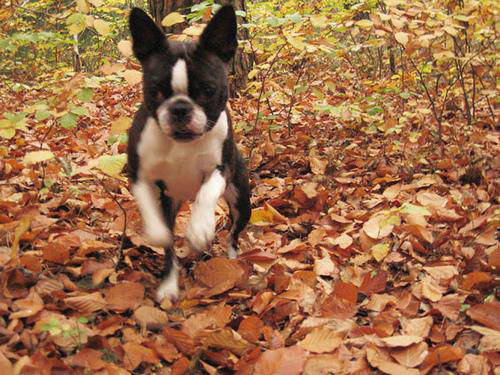

In [9]:
img = PIL.Image.open(PATH+'/train/'+os.listdir(PATH+'train')[0])
img

Let's do some analysis on the dimensions of the images in the training dataset.

In [10]:
img.size

(500, 375)

In [11]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [12]:
row_sz, col_sz = list(zip(*size_d.values()))

In [13]:
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

(array([2870., 5121.,  128.,   25.,   10.,   15.,    5.,    2.,    0.,    2.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

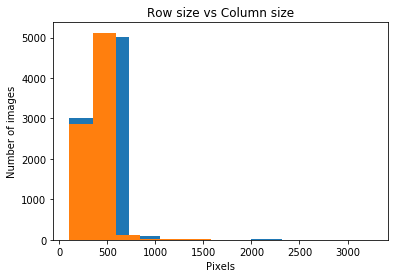

In [14]:
plt.title("Row size vs Column size")
plt.xlabel('Pixels')
plt.ylabel('Number of images')
# plt.legend()
plt.hist(row_sz)
plt.hist(col_sz)

It appears that most of the data have a length and width is between 400 and 500 pixels. Thus doing the modelling with a img size between 400 and 500 would lead to the best results.

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

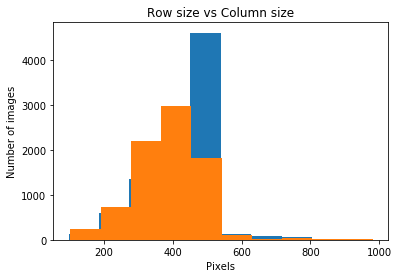

In [15]:
plt.title("Row size vs Column size")
plt.xlabel('Pixels')
plt.ylabel('Number of images')
# plt.legend()
plt.hist(row_sz[row_sz < 1000])
plt.hist(col_sz[col_sz < 1000])

### **Modelling**

### 1. Finding the learning rate

The learning rate refers to how fast the model is able to adjust the weights of the model to be optimal. The lower the learning rate, the more accurate the model would be, however the trade-off being it will be much slower.

It is very important to find the best learning rate which maximises efficiency and accuracy. 

In [5]:
learn = ConvLearner.pretrained(arch, data, pretrained=True, ps=0.5)

epoch      trn_loss   val_loss   accuracy   
    0      4.491116   8.111321   0.357632  



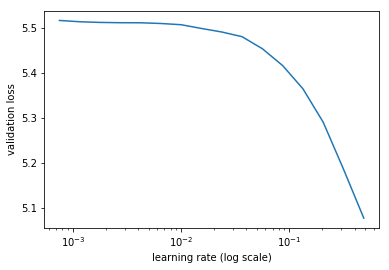

In [6]:
lrf = learn.lr_find()
learn.sched.plot()

In [7]:
lr = 2e-1

### 2. Fit the model using the learning rate

In [8]:
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy   
    0      2.541403   1.112082   0.674658  
    1      1.822543   0.99139    0.709883  
    2      1.537448   0.962198   0.715264  



[array([0.9622]), 0.7152641847175628]

### 3. Turn precompute off

In [22]:
learn.precompute = False

### 4. Re-run the fit

In [10]:
lrs = np.array([lr/9,lr/3,lr])

In [11]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      1.146469   0.920332   0.727984  
    1      1.12663    0.920201   0.726027  
    2      1.063655   0.895593   0.739726  
    3      1.052779   0.913014   0.726027  
    4      1.021434   0.922712   0.727006  
    5      0.974226   0.898623   0.734834  
    6      0.932796   0.891658   0.736791  



[array([0.89166]), 0.7367906067702635]

### 5. & 6. Unfreeze and re-run the fit for varying learning rates

In [ ]:
## Requires a lot of GPU memory, when the layers are unfrozen
# learn.unfreeze()
# learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

### 7. Save the model

In [12]:
# learn.save('sz140acc73')

In [13]:
learn.load('sz140acc73')

### 8. Repeat for a larger image size

#### Img size: 196, Batch size: 128

In [14]:
learn.set_data(get_data(196,128))

epoch      trn_loss   val_loss   accuracy   
    0      1.54457    47.178921  0.126223  



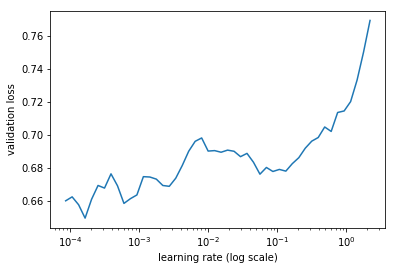

In [15]:
lrf = learn.lr_find()
learn.sched.plot()

In [20]:
lr = 1e-2

In [23]:
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy   
    0      0.661574   0.568384   0.825832  
    1      0.647614   0.568588   0.82681   
    2      0.633718   0.564928   0.822896  



[array([0.56493]), 0.8228962815671051]

In [26]:
lrs = np.array([lr/9,lr/3,lr])

In [27]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.639548   0.581224   0.827789  
    1      0.605093   0.57271    0.830724  
    2      0.586288   0.569781   0.831213  
    3      0.588895   0.566116   0.836106  
    4      0.584422   0.56272    0.831703  
    5      0.564973   0.559968   0.832681  
    6      0.593355   0.560109   0.831703  


[array([0.56011]), 0.83170254473117]

In [28]:
learn.save('sz140acc83')

#### Img size: 392, Batch size: 32

In [29]:
learn.set_data(get_data(392,32))

 85%|████████▍ | 217/256 [03:02<00:32,  1.19it/s, loss=2.87]

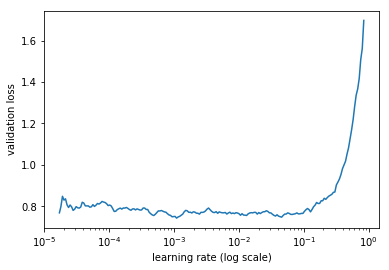

In [30]:
lrf = learn.lr_find()
learn.sched.plot()

In [31]:
lr = 1e-1

In [32]:
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy   
    0      1.164103   0.689835   0.791096  
    1      1.083952   0.704948   0.785225  
    2      1.020308   0.716688   0.789628  


[array([0.71669]), 0.7896281798058526]

In [33]:
lrs = np.array([lr/9,lr/3,lr])

In [34]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.786728   0.496734   0.844423  
    1      0.853571   0.573817   0.828278  
    2      0.641208   0.502733   0.85274   
    3      0.843815   0.582246   0.828767  
    4      0.697518   0.542453   0.83953   
    5      0.599509   0.496513   0.844423  
    6      0.477187   0.487098   0.84638   


[array([0.4871]), 0.8463796476328677]

In [35]:
learn.save('sz140acc85')

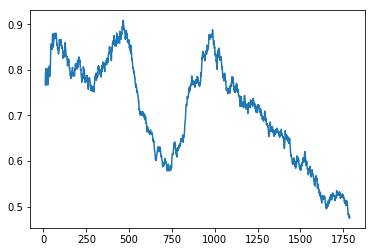

In [36]:
learn.sched.plot_loss()

Now we have a model which predicts the breed of a dog with an accuracy of **84.6%**. Now tests can be performed to validate the integrity of the model.

### **Testing**

### Preparation of data for testing

I created a new folder called 'custom_tests', which includes handpicked dogs, that I can use to test if the model is working correct.

In [38]:
# Making a list of dog breeds
dog_breed = list(zip(data.classes))
dog_breed =["%s" % i for i in dog_breed]
dog_breed[:10]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

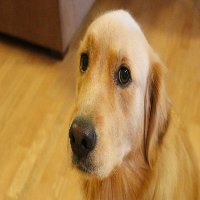

In [70]:
fpn = f'{PATH}custom_tests/'
fn = f'{fpn}1.png'
PIL.Image.open(fn).resize((200,200))

In [81]:
trn_tfms, val_tfms = tfms_from_model(arch, 200)
im = val_tfms(open_image(fn))
preds = learn.predict_array(im[None])
print(dog_breed[np.argmax(preds)], end=', ')
print(f'with a {np.exp((np.amax(preds[0])))*100:.3f}% confidence')

golden_retriever, with a 99.997% confidence


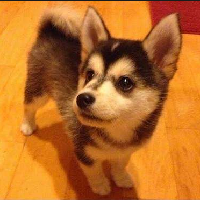

In [82]:
fn = f'{fpn}2.png'
PIL.Image.open(fn).resize((200,200))

In [83]:
im = val_tfms(open_image(fn))
preds = learn.predict_array(im[None])
dog_breed[np.argmax(preds)]
print(dog_breed[np.argmax(preds)], end=', ')
print(f'with a {np.exp((np.amax(preds[0])))*100:.3f}% confidence')

siberian_husky, with a 41.082% confidence


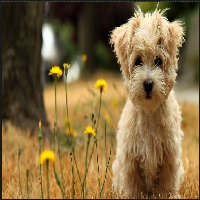

In [84]:
fn = f'{fpn}3.png'
PIL.Image.open(fn).resize((200,200))

In [85]:
im = val_tfms(open_image(fn))
preds = learn.predict_array(im[None])
dog_breed[np.argmax(preds)]
print(dog_breed[np.argmax(preds)], end=', ')
print(f'with a {np.exp((np.amax(preds[0])))*100:.3f}% confidence')

norfolk_terrier, with a 60.698% confidence


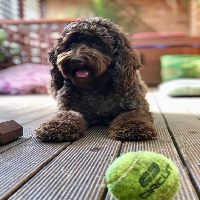

In [86]:
fn = f'{fpn}5.jpg'
PIL.Image.open(fn).resize((200,200))

In [87]:
im = val_tfms(open_image(fn))
preds = learn.predict_array(im[None])
dog_breed[np.argmax(preds)]
print(dog_breed[np.argmax(preds)], end=', ')
print(f'with a {np.exp((np.amax(preds[0])))*100:.3f}% confidence')

bouvier_des_flandres, with a 94.201% confidence


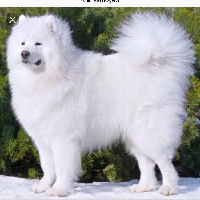

In [88]:
fn = f'{fpn}7.jpg'
PIL.Image.open(fn).resize((200,200))

In [89]:
im = val_tfms(open_image(fn))
preds = learn.predict_array(im[None])
dog_breed[np.argmax(preds)]
print(dog_breed[np.argmax(preds)], end=', ')
print(f'with a {np.exp((np.amax(preds[0])))*100:.3f}% confidence')

samoyed, with a 50.822% confidence


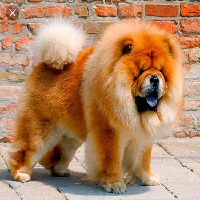

In [90]:
fn = f'{fpn}6.jpg'
PIL.Image.open(fn).resize((200,200))

In [91]:
im = val_tfms(open_image(fn))
preds = learn.predict_array(im[None])
dog_breed[np.argmax(preds)]
print(dog_breed[np.argmax(preds)], end=', ')
print(f'with a {np.exp((np.amax(preds[0])))*100:.3f}% confidence')

chow, with a 100.000% confidence


### **Submission to Kaggle**

In [111]:
temp = learn.predict(is_test=True)

In [139]:
test_files = data.test_dl.dataset.fnames
test_files = [x[5:] for x in test_files]
test_files = [x[:-4] for x in test_files]
test_files[:5]
#test_files = [x.strip('.jpg') for x in test_files]
#test_files[9000:9010]

['000621fb3cbb32d8935728e48679680e',
 '00102ee9d8eb90812350685311fe5890',
 '0012a730dfa437f5f3613fb75efcd4ce',
 '001510bc8570bbeee98c8d80c8a95ec1',
 '001a5f3114548acdefa3d4da05474c2e']

In [140]:
results_dog = np.argmax(temp, axis=1)
results_dog[:20]

array([ 61,  94,  40,  88,  70, 105,   6,  94,  59, 107, 109,  98,  78,  81,   9,  69, 111, 103,  57,  93],
      dtype=int64)

In [141]:
probability = np.exp(temp)
probability

array([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.00115, 0.     , ..., 0.     , 0.     , 0.     ],
       ...,
       [0.     , 0.     , 0.00002, ..., 0.     , 0.     , 0.     ],
       [0.00096, 0.     , 0.     , ..., 0.     , 0.     , 0.00111],
       [0.     , 0.     , 0.     , ..., 0.00007, 0.     , 0.     ]], dtype=float32)

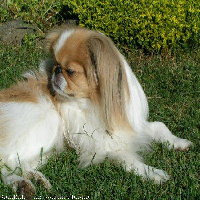

In [142]:
PIL.Image.open(PATH+'test/'+test_files[0]+'.jpg').resize((200,200))

In [143]:
print(dog_breed[results_dog[0]], end=', ')
print(f'with a {np.amax(probability[0])} confidence')

japanese_spaniel, with a 0.9928331971168518 confidence


In [144]:
submission = pd.DataFrame(data=probability, index=test_files, columns=dog_breed)
submission.index.name = 'id'

In [145]:
submission.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
000621fb3cbb32d8935728e48679680e,3.475382e-08,1.116879e-08,1.588644e-08,4.814167e-09,1.428154e-10,3.115749e-10,2.403320e-09,2.794165e-10,3.050391e-09,1.933143e-08,...,1.190971e-07,2.745632e-08,5.587512e-10,9.683160e-10,1.485057e-10,9.032987e-09,7.998624e-11,1.627254e-09,8.785872e-08,1.638851e-08
00102ee9d8eb90812350685311fe5890,7.418256e-12,9.908110e-12,6.901675e-12,1.652197e-11,8.712438e-10,6.661272e-12,1.911826e-10,4.385725e-12,7.990386e-12,1.062845e-11,...,8.674599e-10,5.426531e-10,2.719886e-10,3.149687e-10,4.376486e-11,1.560895e-11,1.991239e-07,4.159686e-12,1.113429e-11,2.721763e-11
0012a730dfa437f5f3613fb75efcd4ce,9.521438e-11,1.151728e-03,1.914494e-07,5.331178e-08,5.214950e-11,4.878027e-09,2.162470e-09,8.733098e-11,2.182327e-07,2.054920e-09,...,7.946955e-10,6.935293e-10,5.584798e-07,3.723802e-07,1.799721e-07,6.152852e-05,7.792538e-09,4.428824e-08,5.615046e-09,4.837964e-08
001510bc8570bbeee98c8d80c8a95ec1,3.364247e-04,1.410150e-08,3.154326e-08,3.918192e-09,8.561234e-06,3.495557e-07,3.830882e-09,9.423457e-08,6.126185e-08,5.685812e-08,...,1.623272e-07,1.467301e-08,1.914712e-06,1.445914e-07,5.223215e-06,3.547240e-09,4.013430e-08,1.747949e-06,1.263393e-07,4.580151e-08
001a5f3114548acdefa3d4da05474c2e,2.504145e-03,5.511611e-07,4.342550e-08,9.624023e-09,4.314478e-09,4.953548e-10,7.372770e-07,1.289104e-09,1.893230e-08,3.043941e-08,...,2.480495e-07,2.998299e-08,4.425371e-08,7.207511e-09,1.597221e-08,6.465082e-10,2.623421e-08,2.869630e-09,1.128936e-06,3.538784e-06


In [146]:
submission.to_csv(f'{PATH}csv/output.csv')